In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from functools import reduce
import directlfq.lfq_manager as lfq_manager
import upsetplot as up
import math
from data_tools.iterables import similarity
import scipy.stats as stat
import scipy.cluster.hierarchy as hierarchy
from sklearn.decomposition import PCA 
from sklearn.impute import KNNImputer

In [96]:
fontsize = 16
lw = 2
size = 25
props = dict(boxstyle='round, pad=0.5', facecolor='white', edgecolor='black', 
             linewidth=2, mutation_aspect=0.8, pad=0.3)

blues = sns.color_palette('Blues', 20)
greens = sns.color_palette('Greens', 5)
greys = sns.color_palette('Greys', 20)

palette = [blues[1], blues[7], blues[13], blues[19]]
palette2 = [greys[0], greys[3], greys[6], greys[9]]

cmap = 'viridis_r'
cmap2 = 'RdBu_r'
gamma = '\u03B3'
interferon = 'IFN-' + gamma

In [97]:
path = '01_Data/01_Reports/'

reports = [pd.read_csv(path + 'mbr.report.tsv', sep='\t'), 
           pd.read_csv(path + '+5xME_0h+24h.report.tsv', sep='\t'),
           pd.read_csv(path + '+10xME_0h+24h.report.tsv', sep='\t'), 
           pd.read_csv(path + '+50xME_0h+24h.report.tsv', sep='\t')]

names = ['MBR', '+5xME', '+10xME', '+50xME']

In [98]:
path2 = '01_Data/02_Filtered_Reports/'

for i, frame in enumerate(reports):
    
    frame = frame[frame['Q.Value'] <= 0.01]
    frame = frame[frame['Lib.Q.Value'] <= 0.01]
    frame = frame[frame['Lib.PG.Q.Value'] <= 0.01]
    
    reports[i] = frame[~frame['Run'].str.contains('ng')] # removing MEs
    reports[i].to_csv(path2 + 'f_' + names[i] + '_report.tsv', sep='\t')

    lfq_manager.run_lfq(path2 + 'f_' + names[i] + '_report.tsv') # directLFQ normalization
#     Manual transfer to '01_Data/03_DirectLFQ_Quan/'

In [99]:
path3 = '01_Data/03_DirectLFQ_Quan/'

dataframes = []
for name in names:
    frame = pd.read_csv(path3 + 'f_' + name + '_report.tsv.protein_intensities.tsv', sep='\t')
    frame.replace(0, np.nan, inplace=True)
    dataframes.append(frame)

In [100]:
quans = []
for i, frame in enumerate(dataframes):
    
    c24_cols = [c for c in frame if 'c_24h' in c]
    frame = frame.drop(columns=c24_cols)
    
    quan_cols = [c for c in frame if '_KK_' in c]
    quan = frame[['Protein.Group', 'Genes'] + quan_cols].set_index(['Protein.Group', 'Genes'])
    
    new_cols = ['_'.join(c.split('_')[4:6]) for c in quan]
    quan.columns = new_cols
    
    quans.append(quan)

C:\Users\k689l\AppData\Local\Temp\ipykernel_13952\1190779264.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=40, ha='right', rotation_mode='anchor', weight='bold')


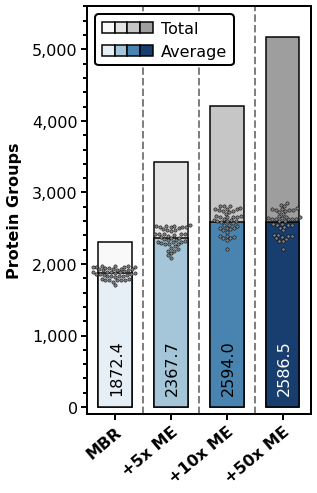

In [101]:
counts = pd.DataFrame()
totals = pd.DataFrame()

for i, frame in enumerate(quans):
    counts[names[i]] = frame.count()
    totals[names[i]] = [len(frame)]

labels = [name.replace('x', 'x ') for name in names]     
fig, ax = plt.subplots(1, 1, figsize=(4,7.5))

sns.barplot(data=totals, palette=palette2, edgecolor='k', linewidth=lw-0.5, width=0.6, ax=ax)
sns.barplot(data=counts, palette=palette, edgecolor='k', linewidth=lw-0.5, width=0.6, errorbar=None, ax=ax)           
sns.swarmplot(data=counts, color='grey', edgecolor='k', linewidth=0.5, s=3.3, dodge=True)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    
ax.set_ylabel('Protein Groups', fontsize=fontsize, fontweight='bold', labelpad=10)
ax.set_xlabel('')
ax.set_ylim([-100, 5600])
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.minorticks_on()
ax.tick_params(axis='both', which='major', direction='out', length=lw*3, width=lw, labelsize=fontsize)
ax.tick_params(axis='x', which='minor', length=0)
ax.tick_params(axis='y', which='minor', direction='out', length=lw*2, width=lw)

ax.set_xticklabels(labels, rotation=40, ha='right', rotation_mode='anchor', weight='bold')

patches = [ax.patches[0], ax.patches[4], ax.patches[1], ax.patches[5], 
           ax.patches[2], ax.patches[6], ax.patches[3], ax.patches[7]]

legend = ax.legend(handles=patches, labels=['', '', '', '','', '', 'Total', 'Average'], ncol=4, columnspacing=-0.5, 
                   handlelength=0.8, handletextpad=0.5, fontsize=fontsize, loc=2, edgecolor='k', framealpha=1)
legend.get_frame().set_linewidth(2)

for i in range(3):
    ax.axvline(x=(0.5+i), linestyle='dashed', color='grey', lw=lw)

for i in range(len(counts.columns)):
    if i == 3:
        ax.text(x=-0.11+i, y=200, s=str(round(counts.iloc[:,i].mean(),1)), fontsize=fontsize, rotation=90, color='white')
    else:
        ax.text(x=-0.11+i, y=200, s=str(round(counts.iloc[:,i].mean(),1)), fontsize=fontsize, rotation=90)
        
# plt.savefig('02_Figures/IFN_low-input_ProteinGroups_Barplot.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/IFN_low-input_ProteinGroups_Barplot.pdf', dpi=400, bbox_inches='tight')    

Text(-0.23, 2870, '10x DIA-ME')

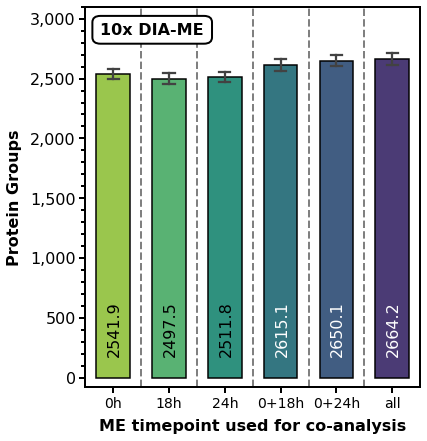

In [102]:
path4 = '01_Data/04_MaxLFQ_output/'

search_quans = [pd.read_csv(path4 + '+10ME_0h.pg_matrix.tsv', sep='\t'),
                pd.read_csv(path4 + '+10ME_18h.pg_matrix.tsv', sep='\t'),
                pd.read_csv(path4 + '+10ME_24h.pg_matrix.tsv', sep='\t'),
                pd.read_csv(path4 + '+10ME_0h+18h.pg_matrix.tsv', sep='\t'),
                pd.read_csv(path4 + '+10ME_0h+24h.pg_matrix.tsv', sep='\t'),
                pd.read_csv(path4 + '+10ME_all.pg_matrix.tsv', sep='\t')]

se_names = ['0h', '18h', '24h', '0+18h', '0+24h', 'all']

se_counts = pd.DataFrame()
for i, frame in enumerate(search_quans):
    frame = frame[[c for c in frame.columns if 'KK' in c]].drop(columns=[c for c in frame.columns if 'ng' in c])
    frame.columns = [c.split('\\')[-1] for c in frame]
    se_counts[se_names[i]] = frame.count()

fig, ax = plt.subplots(1, 1, figsize=(6,7))

sns.barplot(data=se_counts, palette=cmap, edgecolor='black', linewidth=lw-0.5, width=0.6, capsize=0.2, ax=ax)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

ax.set_ylabel('Protein Groups', fontsize=fontsize, fontweight='bold', labelpad=8)
ax.set_xlabel('ME timepoint used for co-analysis', fontsize=fontsize, fontweight='bold', labelpad=8)
ax.set_ylim([-80, 3100])

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.minorticks_on()
ax.tick_params(axis='both', which='major', direction='out', length=lw*3, width=lw, labelsize=fontsize)
ax.tick_params(axis='x', which='major', labelsize=fontsize-2)
ax.tick_params(axis='x', which='minor', length=0)
ax.tick_params(axis='y', which='minor', direction='out', length=lw*2, width=lw)

for i in range(5):
    ax.axvline(x=(0.5+i), linestyle='dashed', color='grey', linewidth=lw)
    
for i in range(len(se_counts.columns)):
    if i > 2:
        ax.text(x=-0.11+i, y=200, s=str(round(se_counts.iloc[:,i].mean(),1)), fontsize=fontsize, rotation=90, color='white')
    else:
        ax.text(x=-0.11+i, y=200, s=str(round(se_counts.iloc[:,i].mean(),1)), fontsize=fontsize, rotation=90)
        
ax.text(-0.23, 2870, '10x DIA-ME', fontsize=fontsize, fontweight='bold', bbox=props)

# plt.savefig('02_Figures/IFN_low-input_ProteinGroups_Barplot_Tp-Searches.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/IFN_low-input_ProteinGroups_Barplot_Tp-Searches.pdf', dpi=400, bbox_inches='tight')   

C:\Users\k689l\AppData\Local\Temp\ipykernel_13952\2241745127.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(timepoints, rotation = 270, ha='center', va='top')


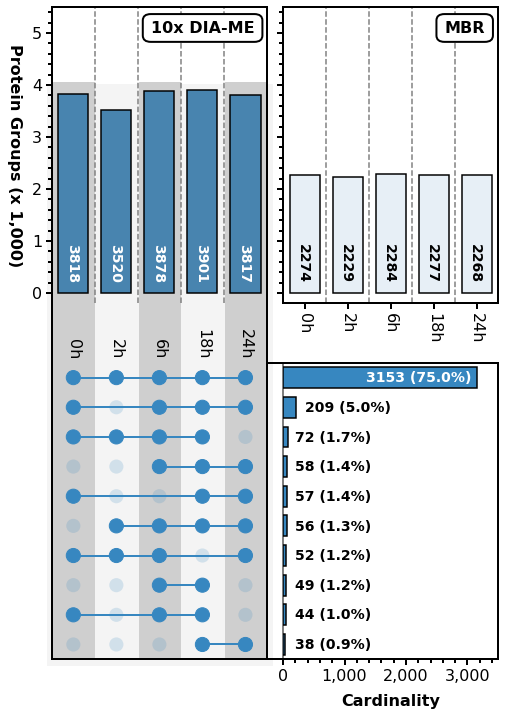

In [103]:
quans_of_interest = [quans[0], quans[2]]   # quans[0] => mbr, quans[2] => 10xDIA-ME

timepoints = ['0h', '2h', '6h', '18h', '24h']
tp_labels = [tp.replace('h', ' h') for tp in timepoints]

indicators = []
indic_counts = []

for i, frame in enumerate(quans_of_interest):
    df = frame.copy()
    df.columns = [c.split('_')[0] for c in df]
    
    indicator = pd.DataFrame(index=df.index)
    for tp in timepoints:
        tp_frame = df[tp]
        indicator[tp] = np.where(tp_frame.isna().all(axis=1), False, True)
    indicators.append(indicator)
    indic_counts.append(indicator.replace(False,np.nan).count())
    
upset_data = up.from_indicators(indicators[1])

fig, ax = plt.subplots(2,2, figsize=(8,12))
plt.subplots_adjust(hspace=0.2, wspace=0.075)
axs = fig.axes

sns.barplot(data=indic_counts[0].div(1000), color=blues[1], 
            edgecolor='black', linewidth=lw-0.5, order=timepoints, width=0.7, ax=axs[1])
sns.barplot(data=indic_counts[1].div(1000), color=blues[13], 
            edgecolor='black', linewidth=lw-0.5, order=timepoints, width=0.7, ax=axs[0])
    
for i in range(2):
    for axis in ['bottom', 'top', 'left', 'right']:
        axs[i].spines[axis].set_visible(True)
        axs[i].spines[axis].set_linewidth(lw)
    axs[i].set_ylim([-0.2, 5.500])
    
    axs[i].minorticks_on()
    axs[i].tick_params(axis='x', which='major', direction='out', length=lw*3, width=lw, labelsize=fontsize)
    axs[i].tick_params(axis='x', which='minor', length=0)
    axs[i].set_xticklabels(timepoints, rotation = 270, ha='center', va='top')
    
    axs[i].tick_params(axis='y', which='major', direction='out', length=lw*3, width=lw, labelsize=fontsize)
    axs[i].tick_params(axis='y', which='minor', direction='out', length=lw*2, width=lw)
    
    for j in range(4):
        axs[i].axvline(x=(0.5+j), linestyle='dashed', color='grey', lw=1.5)
    
for i in range(5):
    axs[0].text(-0.2+i, 0.25, indic_counts[1][i], fontsize=fontsize-2, 
                weight='bold', rotation=270, color='white', zorder=10)
    axs[1].text(-0.2+i, 0.25, indic_counts[0][i], fontsize=fontsize-2, 
                weight='bold', rotation=270, color='k', zorder=10)

axs[0].spines['bottom'].set_visible(False)
axs[0].get_xaxis().set_visible(False)

axs[0].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
axs[0].set_ylabel('Protein Groups (x 1,000)', fontweight='bold', fontsize=fontsize, labelpad=25, rotation=270)
axs[1].set_yticklabels([])  
 
axs[0].text(1.8, 5.010, '10x DIA-ME', fontweight='bold', fontsize=fontsize, bbox=props)  
axs[1].text(3.25, 5.010, 'MBR', fontweight='bold', fontsize=fontsize, bbox=props)

upset = up.UpSet(pd.DataFrame(upset_data), element_size=None, orientation='vertical', sort_by='cardinality',
                 sort_categories_by=None, min_subset_size=38, facecolor=blues.as_hex()[13], shading_color='gainsboro',
                 show_percentages=False, show_counts=False)

upset.plot_matrix(ax=axs[2])
upset.plot_intersections(ax=axs[3])

axs[2].set_xlim([-0.5, 4.5])
axs[2].set_xticklabels(timepoints, fontsize=fontsize)

axs[3].set_xlabel('Cardinality', fontweight='bold', fontsize=fontsize, labelpad=10)
axs[3].set_xlim([0, 3500])
axs[3].set_xticks([0, 1000, 2000, 3000])
axs[3].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
axs[3].set_ylim([-0.5, 9.5])
axs[3].minorticks_on()
axs[3].tick_params(axis='x', which='major', direction='out', length=lw*3, width=lw, labelsize=fontsize)
axs[3].tick_params(axis='x', which='minor', direction='out', length=lw*2, width=lw)
axs[3].grid(False)
axs[3].axvline(x=0, ymin=0, color='grey',linestyle='solid', linewidth=2, clip_on=False)

bars = axs[3].patches
for bar in bars:
    bar.set_edgecolor('black')
    bar.set_linewidth(lw-0.5)
    
rect_color = '#f4f4f4'
rect_color2 = '#cfcfcf'
rectangle = mpl.patches.Rectangle((-0.6, -7.150), width=5.22, height=11.15, linewidth=lw, edgecolor=rect_color, 
                                 facecolor=rect_color, clip_on=False, zorder=0)
axs[0].add_patch(rectangle)
for i in range(3):
    rect = mpl.patches.Rectangle((-0.48+2*i, -7), width=0.95, height=11.05, linewidth=lw/2, edgecolor=rect_color2,
                                  facecolor=rect_color2, clip_on=False, zorder=0)
    axs[0].add_patch(rect)
    
# making outline of upset
axs[0].axvline(x=-0.5, ymin=-1.2, color='k', linestyle='solid', linewidth=lw, clip_on=False)
axs[0].axvline(x=4.5, ymin=-1.2, color='k', linestyle='solid', linewidth=lw, clip_on=False)
axs[2].axhline(y=9.5, xmin=1, xmax=1.1, color='k',linestyle='solid', linewidth=lw, clip_on=False)
axs[2].axhline(y=-0.5, xmax=1.1, color='k',linestyle='solid', linewidth=lw, clip_on=False)

for axis in ['top', 'bottom', 'right']:
    axs[3].spines[axis].set_visible(True)
    axs[3].spines[axis].set_linewidth(lw)

for patch in axs[3].patches:
    diff = patch.get_height() - 0.7
    patch.set_height(0.7)
    patch.set_y(patch.get_y() + diff * .5)

# one can get cardinality labels from activatiing labels in the upset function
c_labels = ['3153 (75.0%)', '209 (5.0%)', '72 (1.7%)', '58 (1.4%)', '57 (1.4%)', 
            '56 (1.3%)', '52 (1.2%)', '49 (1.2%)', '44 (1.0%)', '38 (0.9%)']
for i in range(len(c_labels)):
    if i == 0:
        axs[3].text(1350, 8.85-i, s=c_labels[i], fontsize=fontsize-2, fontweight='bold', rotation=0, color='white', zorder=10)
    elif i == 1:
        axs[3].text(350, 8.85-i, s=c_labels[i], fontsize=fontsize-2, fontweight='bold', rotation=0, color='k')
    else:
        axs[3].text(200, 8.85-i, s=c_labels[i], fontsize=fontsize-2, fontweight='bold', rotation=0, color='k')

# plt.savefig('02_Figures/IFN_low-input_ProteinGroups_UpSet_Plot.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/IFN_low-input_ProteinGroups_UpSet_Plot.pdf', dpi=400, bbox_inches='tight') 

Text(0.56, 0.5, '+10x ME')

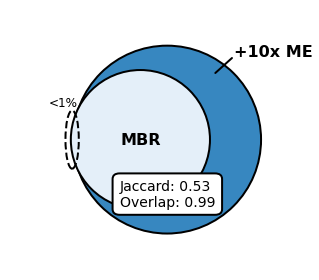

In [104]:
def venn(N, labels=['', ''], labelsize=14, c=['C0', 'C1'], alpha=0.6, lw=1, edgecolor=None):
    def ellipse(ax, x, y, w, h, a, color, alpha=alpha, lw=lw, label=None, zorder=0):
        e = mpl.patches.Ellipse(xy=(x, y), width=w, height=h, angle=a, edgecolor=edgecolor, lw=lw,
                                facecolor=color, alpha=alpha, label=label, zorder=zorder)
        ax.add_patch(e)

    sizeA, sizeB = len(N[0]), len(N[1])
    rel = max(sizeA, sizeB)
    relsizeA, relsizeB = math.sqrt(sizeA / rel / math.pi)*2, math.sqrt(sizeB / rel / math.pi)*2
    ra, rb = relsizeA / 2, relsizeB / 2

    s = similarity(N[0], N[1], mode='ss')
    rx = max(ra, rb) + min(ra, rb) * (1 - 2 * s)

    # Ellipse parameters
    x = [0, rx]
    y = [0, 0]
    w = [relsizeA, relsizeB]
    h = [relsizeA, relsizeB]
    a = [0, 0]

    for i in range(len(N)):
        
        if sizeB > sizeA:
            zorder = 1 - i
            
        ellipse(ax, x[i], y[i], w[i], h[i], a[i], alpha=alpha, color=c[i],
                lw=lw, label=labels[i], zorder=zorder)
        ax.text(x[i], y[i], labels[i], fontsize=labelsize)
        
    ax.set_xlim(-0.8, 0.8)
    ax.set_ylim(-0.8, 0.8)

    ax.axis('off')
    fig.tight_layout()


mbr_pglist = quans_of_interest[0].index.get_level_values(0).to_list()
diame_pglist = quans_of_interest[1].index.get_level_values(0).to_list()

fig, ax = plt.subplots(1,1,figsize=(4,4))

venn(N=[mbr_pglist, diame_pglist], labelsize=fontsize, c=[blues[1], blues[13]], alpha=1, edgecolor='k', lw=2)
  
ellipse = mpl.patches.Ellipse((-0.41,0), width=0.08, height=0.35, lw=lw, edgecolor='k', 
                              zorder=5, facecolor='none', linestyle='dashed')
ax.add_artist(ellipse)

ax.text(-0.12,-0.03, 'MBR', fontsize=fontsize, fontweight='bold')
ax.text(-0.55, 0.2, '<1%', fontsize=fontsize-4)

ax.text(x=-0.125, y=-0.4, s='Jaccard: 0.53 Overlap: 0.99',  # manual calculation
        fontsize=fontsize-2, wrap=True, bbox=props)._get_wrap_line_width = lambda : 100.

xt = 0.55
yt = 0.49
con = mpl.patches.ConnectionPatch(xyA=(0.45,0.4), xyB=(xt,yt), coordsA='data', coordsB='data',
                                  axesA=ax, color='k', linewidth=lw)
ax.add_artist(con)
ax.text(xt+0.01,yt+0.01, '+10x ME', fontsize=fontsize, fontweight='bold', color='k')

# plt.savefig('02_Figures/IFN_low-input_ProteinGroups_Venn_Plot.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/IFN_low-input_ProteinGroups_Venn_Plot.pdf', dpi=400, bbox_inches='tight')

Text(0, 1.5, 'Median')

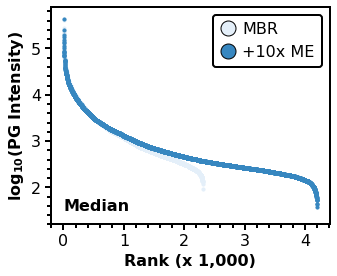

In [105]:
fig, ax = plt.subplots(1,1,figsize=(5,4))

handles = []
for i, frame in enumerate(quans_of_interest):
    
    frame = np.log10(frame)
    frame['Median'] = frame.median(axis=1)
    frame['Rank'] = frame['Median'].rank(ascending=False)    

    ax.scatter(frame['Rank']/1000, frame['Median'], color=palette[2*i], s=10)
    handles.append(mpl.lines.Line2D([0], [0], lw=0, marker='o', color='k', label=labels[2*i],
                                    markerfacecolor=palette[2*i], markersize=15, markeredgewidth=1))
    
for axis in ['bottom', 'top', 'left', 'right']:
    ax.spines[axis].set_linewidth(lw)

ax.set_ylim([1.2, 5.9])
ax.set_ylabel('log'+r'$\bf{_{10}}$'+'(PG Intensity)', fontsize=fontsize, fontweight='bold', labelpad=5)
ax.set_xlabel('Rank (x 1,000)', fontsize=fontsize, fontweight='bold', labelpad=5)

ax.minorticks_on()
ax.tick_params(axis='both', which='major', length=lw*3, width=lw, labelsize=fontsize)
ax.tick_params(axis='both', which='minor', length=lw*2, width=lw)

legend = ax.legend(handles=handles, fontsize=fontsize, handlelength=1, handletextpad=0.4,
                   edgecolor='k', framealpha=1, borderpad=0.45)
legend.get_frame().set_linewidth(2)
ax.text(x=0, y=1.5, s='Median', fontsize=fontsize, weight='bold')

# plt.savefig('02_Figures/IFN_low-input_ProteinGroups_Rank_Plot.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/IFN_low-input_ProteinGroups_Rank_Plot.pdf', dpi=400, bbox_inches='tight')

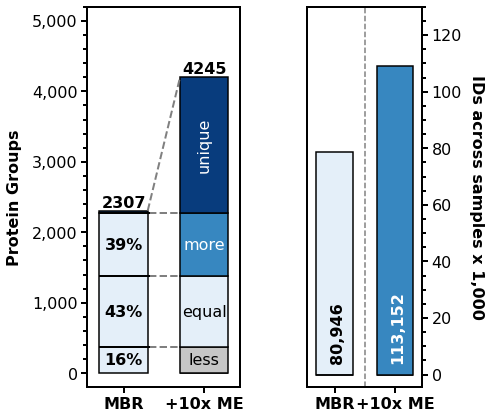

In [106]:
val_counts = []
for i, frame in enumerate(quans_of_interest):
    
    df = frame.copy()
    df['count'] = df.count(axis=1)
    val_counts.append(pd.DataFrame(df['count']))

val_counts = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True, how='outer'), val_counts)
val_counts.columns = [labels[0], labels[2]]
val_counts['without ME'] = np.where(val_counts[labels[0]].isna(), '', '+')
val_counts['Difference'] = val_counts[labels[2]].sub(val_counts[labels[0]].replace(np.nan,0))
val_wo_ME = val_counts[val_counts['without ME'] == '+']

stacked_bars = [
                [len(val_wo_ME.dropna(subset=labels[2])), 0],       # shared between analyses
                [0, len(val_wo_ME[val_wo_ME['Difference'] < 0])],   # decrease by DIA-ME
                [0, len(val_wo_ME[val_wo_ME['Difference'] == 0])],  # unchanged
                [0, len(val_wo_ME[val_wo_ME['Difference'] > 0])],   # increase by DIA-ME
                [val_wo_ME[labels[2]].isna().value_counts()[1],     # unique in either of the analysis
                 len(val_counts[val_counts['without ME'] != '+'])]
               ]

colors = [blues[1], greys[6], blues[1], blues[13], blues[19]]
tag = ['', 'less', 'equal', 'more', 'unique']

fig, ax = plt.subplots(1, 2, figsize=(6,7), gridspec_kw={'width_ratios': [4, 3]})
plt.subplots_adjust(wspace=0.5)
axs = fig.axes

bottom = [0, 0]
for i, layer in enumerate(stacked_bars):
    
    axs[0].bar([labels[0], labels[2]], layer, width=0.6, color=colors[i], edgecolor='k', linewidth=1.5, bottom=bottom)
    
    if i < 3:
        axs[0].text(x=1, y=bottom[1] + layer[1]/2, s=tag[i], ha='center', va='center', fontsize=fontsize, color='k')
    if i > 0 and i < 4:
        axs[0].axhline(xmin=0.4, xmax=0.6, y=bottom[1] + layer[1], linestyle='dashed', color='grey', lw=lw)
        axs[0].axhline(xmin=0.08, xmax=0.4, y=bottom[1] + layer[1], color='k', lw=lw)
        axs[0].text(x=0, y=bottom[1] + layer[1]/2, s=str(round(layer[1]/len(val_wo_ME) *100)) + '%', fontsize=fontsize,
            fontweight='bold', ha='center', va='center')
    if i == 3:
        axs[0].text(x=1, y=bottom[1] + layer[1]/2, s=tag[i], ha='center', va='center', fontsize=fontsize, color='white')
    if i == 4:
        axs[0].text(x=1, y=bottom[1] + layer[1]/2, s=tag[i], ha='center', va='center', fontsize=fontsize, color='white', rotation=90)
        axs[0].text(x=0, y=bottom[0] + layer[0] + 50, s=str(len(val_wo_ME)), fontsize=fontsize, fontweight='bold', ha='center')
        axs[0].text(x=1, y=bottom[1] + layer[1] + 50, s=str(len(val_counts)), fontsize=fontsize, fontweight='bold', ha='center')
   
        xx, yy = [0.3, 0.7], [len(val_wo_ME), len(val_counts)-50]
        axs[0].plot(xx, yy, linestyle='--', color='grey', lw=lw)

    bottom[0] += layer[0]
    bottom[1] += layer[1]

axs[0].set_ylim([-200, 5200])
axs[0].set_xlim([-0.45, 1.45])
axs[0].set_ylabel('Protein Groups', fontsize=fontsize, fontweight='bold', labelpad=10)
axs[0].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

# -----
axs[1].bar([labels[0], labels[2]], [val_counts[labels[0]].sum()/1000, 0], width=0.6, 
           color=blues[1], edgecolor='black', linewidth=1.5)
axs[1].bar([labels[0], labels[2]], [0, val_counts[labels[2]].sum()/1000], width=0.6, 
           color=blues[13], edgecolor='black', linewidth=1.5)

axs[1].text(-0.08, 5, '80,946', rotation=90, fontweight='bold', fontsize=fontsize, color='black')
axs[1].text(0.92, 5, '113,152', rotation=90, fontweight='bold', fontsize=fontsize, color='white')

axs[1].yaxis.set_label_position('right')
axs[1].yaxis.tick_right()

axs[1].set_ylim([-4.5, 130])
axs[1].set_xlim([-0.45, 1.45])
axs[1].set_ylabel('IDs across samples x 1,000', rotation=270, fontsize=fontsize, fontweight='bold', labelpad=22)
axs[1].axvline(x=0.5, linestyle='dashed', color='grey', linewidth=lw-0.5)

for ax in axs:
    for axis in ['bottom', 'top', 'left', 'right']:
        ax.spines[axis].set_linewidth(lw)
    
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', length=lw*3, width=lw, labelsize=fontsize)
    ax.tick_params(axis='x', which='minor', length=0)
    ax.tick_params(axis='y', which='minor', length=lw*2, width=lw)
    plt.setp(ax.get_xticklabels(), fontsize=fontsize, fontweight='bold')
    
# plt.savefig('02_Figures/IFN_low-input_ProteinGroups_Datapoints_Barplot.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/IFN_low-input_ProteinGroups_Datapoints_Barplot.pdf', dpi=400, bbox_inches='tight')

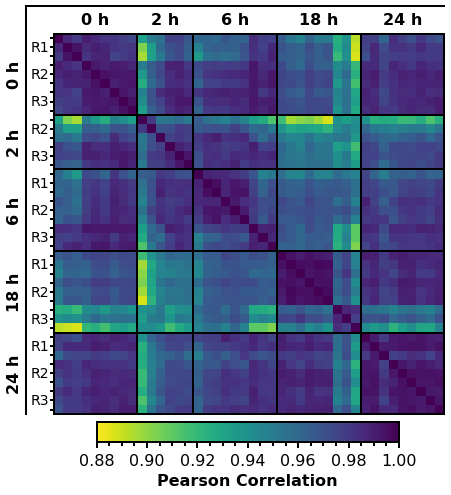

In [107]:
diame = quans[2].copy()
diame.columns = [c.split('_')[0] for c in diame.columns]

pearson = diame[timepoints].corr(method='pearson')

rep_labels = ['','R1','','','R2','','','R3','',
              '','R2','','','R3','',
              '','R1','','','R2','','','R3','',
              '','R1','','','R2','','','R3','',
              '','R1','','','R2','','','R3','']

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

cbar_ax = plt.axes([0.21, 0.07, 0.6, 0.04])

hmap = sns.heatmap(pearson, xticklabels=False, yticklabels=rep_labels, vmin=0.88, vmax=1, cmap=cmap, 
                   lw=0, square=False, cbar_kws={'orientation': 'horizontal'}, ax=ax, cbar_ax=cbar_ax)

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_visible(True)
    ax.spines[axis].set_linewidth(lw)
    cbar_ax.spines[axis].set_visible(True)
    cbar_ax.spines[axis].set_linewidth(lw)
    
ax.tick_params(axis='y', which='major', labelsize=fontsize-2, pad=0, length=lw*2, rotation=0, width=lw)

cbar_ax.minorticks_on()
cbar_ax.tick_params(axis='both', which='major', direction='out', pad=5, length=lw*3, width=lw, labelsize=fontsize)
cbar_ax.tick_params(axis='x', which='minor', direction='out', pad=5, length=lw*2, width=lw)
cbar_ax.set_xlabel('Pearson Correlation', fontsize=fontsize, weight='bold', labelpad=5)

counter = 0
for i, tp in enumerate(timepoints):
    
    reps = len(diame[tp].columns)
    
    ax.text(x=-5, y=(counter + reps/2), s=tp_labels[i], va='center', rotation='vertical', 
            fontsize=fontsize, fontweight='bold')
    ax.text(y=-1, x=(counter + reps/2), s=tp_labels[i], ha='center', rotation='horizontal', 
            fontsize=fontsize, fontweight='bold')
    
    ax.axhline(y=(counter + reps), color='k', linewidth=lw)
    ax.axvline(x=(counter + reps), color='k', linewidth=lw)
    
    counter += reps

ax.axvline(x=-3, ymax=1.07, color='k', linestyle='solid', linewidth=lw, clip_on=False)   
ax.axhline(y=-3, xmin=-0.07, color='k', linestyle='solid', linewidth=lw, clip_on=False)   
    
# plt.savefig('02_Figures/IFN_low-input_Pearson_Heatmap.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/IFN_low-input_Pearson_Heatmap.pdf', dpi=400, bbox_inches='tight')

E:\KK\03_Programs\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
E:\KK\03_Programs\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


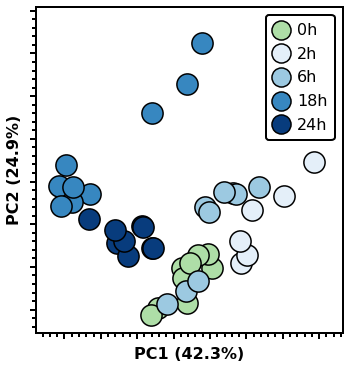

In [108]:
pca_data = diame.dropna().T
pca = PCA(n_components=2).fit_transform(pca_data)
pca = pd.DataFrame(pca, columns=['x','y'])
pca['Timepoint'] = diame.columns

factor = 10000
fig, ax = plt.subplots(1,1, figsize=(5.5, 6))

for i, tp in enumerate(timepoints):
    
    df = pca[pca['Timepoint'] ==  tp].drop(columns='Timepoint').div(factor)
    
    if i == 0:
        sns.scatterplot(data=df, x='x', y='y', s=size*18, color=greens[1], edgecolor='k', linewidth=lw-0.5)
    else:
        sns.scatterplot(data=df, x='x', y='y', s=size*18, color=palette[i-1], edgecolor='k', linewidth=lw-0.5)

for axis in ['bottom', 'top', 'left', 'right']:
    ax.spines[axis].set_linewidth(lw)
    
ax.minorticks_on()
ax.tick_params(axis='both', which='major', length=lw*3, width=lw)
ax.tick_params(axis='both', which='minor', length=lw*2, width=lw)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_xlim([pca['x'].min()*1.2/factor, pca['x'].max()*1.2/factor])
ax.set_ylim([pca['y'].min()*1.2/factor, pca['y'].max()*1.2/factor])

xvar, yvar = PCA(n_components=2).fit(pca_data).explained_variance_ratio_
ax.set_xlabel('PC1 (' + str(round(xvar * 100, 1)) + '%)', weight='bold', fontsize=fontsize)
ax.set_ylabel('PC2 (' + str(round(yvar * 100, 1)) + '%)', weight='bold', fontsize=fontsize)

legend = plt.legend(labels=timepoints, markerscale=0.9, fontsize=fontsize, ncol=1, labelspacing=0.5,
                    handlelength=1, handleheight=1, handletextpad=0.5, edgecolor='k',
                    framealpha=1, borderpad=0.45)
legend.get_frame().set_linewidth(lw)

# plt.savefig('02_Figures/IFN_low-input_PCA_Scatter.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/IFN_low-input_PCA_Scatter.pdf', dpi=400, bbox_inches='tight')

In [109]:
vdata = pd.DataFrame()
medians = pd.DataFrame()
quan_vals = []

for i, tp in enumerate(timepoints):
    medians[tp] = np.log2(diame[tp]).median(axis=1)
    quan_vals.append(diame[tp].to_numpy(dtype=float))
    
    if i > 0:
        vdata['log fold ' + tp + ' - 0h'] = medians[tp].sub(medians['0h'])
        
        pvals = []
        for row in range(medians.shape[0]):
            ttest_result = stat.ttest_ind(quan_vals[i][row, :], quan_vals[0][row, :], nan_policy='omit')
            pvals.append(ttest_result[1])
            
        col_name = 'p-val ' + tp + ' - 0h'
        vdata[col_name] = list(np.array(pvals))
        vdata['log ' + col_name] = -1*np.log10(vdata[col_name])      
        
        rank = vdata[col_name].rank()
        padj = vdata[col_name] * rank.max() / rank
        vdata['log padj ' + tp + ' - 0h'] = -1*np.log10(padj)


E:\KK\03_Programs\Anaconda3\lib\site-packages\scipy\stats\mstats_basic.py:1077: RuntimeWarning: divide by zero encountered in true_divide
  denom = ma.sqrt(svar*(1.0/n1 + 1.0/n2))  # n-D computation here!
C:\Users\k689l\AppData\Local\Temp\ipykernel_13952\1852058514.py:18: UserWarning: Warning: converting a masked element to nan.
  vdata[col_name] = list(np.array(pvals))
E:\KK\03_Programs\Anaconda3\lib\site-packages\scipy\stats\mstats_basic.py:1077: RuntimeWarning: divide by zero encountered in true_divide
  denom = ma.sqrt(svar*(1.0/n1 + 1.0/n2))  # n-D computation here!
C:\Users\k689l\AppData\Local\Temp\ipykernel_13952\1852058514.py:18: UserWarning: Warning: converting a masked element to nan.
  vdata[col_name] = list(np.array(pvals))
E:\KK\03_Programs\Anaconda3\lib\site-packages\scipy\stats\mstats_basic.py:1077: RuntimeWarning: divide by zero encountered in true_divide
  denom = ma.sqrt(svar*(1.0/n1 + 1.0/n2))  # n-D computation here!
C:\Users\k689l\AppData\Local\Temp\ipykernel_13952

In [110]:
path5 = '01_Data/05_Annotation_DB/'
ifn_anno = pd.read_csv(path5 + 'comprehensive_IFNy_interactome.tsv', sep='\t')
anno_set = set(ifn_anno['Entry'])
dictionary = dict(zip(ifn_anno['Entry'], ifn_anno['IFN_Database']))

ifn_proteins = []
for row in vdata.index.get_level_values(0).astype(str):
    ifn = [prot for prot in row.split(';') if prot in anno_set]
    ifn = [dictionary.get(item, item) for item in ifn]  
    ifn_proteins.append(';'.join(ifn))
vdata.loc[:,('IFN_Database')] = ifn_proteins

vdata['without ME'] = ['+' if protein in set(quans[0].index.get_level_values(0)) else np.nan
                       for protein in vdata.index.get_level_values(0)]

path7 = '01_Data/07_Exports/'
# vdata.to_csv(path7 + 'vdata.tsv', sep='\t')

Text(0, 0.5, '')

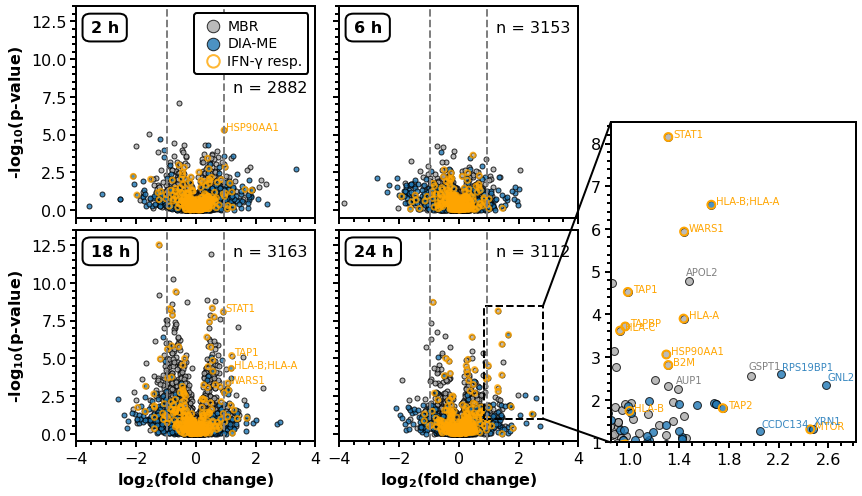

In [111]:
wtME = vdata[vdata['without ME'] != '+']
woME = vdata.dropna(subset='without ME')

ifn_vdata = vdata[vdata['IFN_Database'] != ''].dropna(subset=p_cols, how='all')

ifn_color = 'orange'
alpha = 0.8
fig, ax = plt.subplots(2, 2, figsize=(9, 8), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.06, wspace=0.1)
axs = fig.axes

for i, ax in enumerate(axs):
    
    for axis in ['bottom', 'top', 'left', 'right']:
        ax.spines[axis].set_linewidth(lw)

    tp = timepoints[i+1]
    fc = 'log fold ' + tp + ' - 0h'
    pval = 'log p-val ' + tp + ' - 0h'
    
    sns.scatterplot(data=woME, x=fc, y=pval, s=size, color='darkgrey', alpha=alpha, edgecolor='black', lw=1, ax=ax)
    sns.scatterplot(data=wtME, x=fc, y=pval, s=size, alpha=alpha, edgecolor='black', lw=1, ax=ax)
    
    ifn_tp = ifn_vdata[~ifn_vdata[fc].isna()]
    sns.scatterplot(data=ifn_tp, x=fc, y=pval, s=size, color='none', alpha=alpha, edgecolor=ifn_color, lw=lw, ax=ax)
    
    if i < 3:
        for j in range(ifn_tp.shape[0]):
            if ifn_tp[fc][j] > 0.9 and ifn_tp[pval][j] > 3:
                ax.text(x=ifn_tp[fc][j]+0.08, y=ifn_tp[pval][j], s=ifn_tp['IFN_Database'][j], 
                        fontsize=fontsize-6, c=ifn_color)

    if i == 0:
        ax.text(1.25, 7.8, 'n = ' + str(len(vdata.dropna(subset='log p-val ' + tp + ' - 0h'))), fontsize=fontsize)
    else:
        ax.text(1.25, 11.8, 'n = ' + str(len(vdata.dropna(subset='log p-val ' + tp + ' - 0h'))), fontsize=fontsize)
    
    ax.axvline(x=0.95, color='grey', linestyle='dashed', linewidth=lw)
    ax.axvline(x=-0.95, color='grey', linestyle='dashed', linewidth=lw)
    
    ax.set_xlim([-4, 4])
    ax.set_ylim([-0.5, 13.5])
    
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', labelsize=fontsize, length=lw*3, width=lw)
    ax.tick_params(axis='both', which='minor', labelsize=fontsize, length=lw*2, width=lw)
    
    ax.set_ylabel('-log'+r'$\bf{_{10}}$'+'(p-value)', fontsize=fontsize, weight='bold', labelpad=5)   
    ax.set_xlabel('log'+r'$\bf{_{2}}$'+'(fold change)', fontsize=fontsize, weight='bold')

    ax.text(-3.52, 11.8, tp_labels[i+1], fontsize=fontsize, weight='bold', bbox=props)

legend = axs[0].legend(labels=['MBR', 'DIA-ME', interferon + ' resp.'], markerscale=2.5, fontsize=fontsize-2,
                       ncol=1, columnspacing=1.1, handletextpad=0,  edgecolor='black',  framealpha=1, labelspacing=0.25)
legend.get_frame().set_linewidth(2)

# zoom in
z_ax = plt.axes([0.95, 0.123, 0.378, 0.556])

xy_cord = [0.85, 2.82, 1, 8.5] 
z_ax.set_xlim([xy_cord[0], xy_cord[1]])
z_ax.set_ylim([xy_cord[2], xy_cord[3]])

rect = mpl.patches.Rectangle(xy=(xy_cord[0], xy_cord[2]), width=xy_cord[1]-xy_cord[0], height=xy_cord[3]-xy_cord[2], 
                             lw=lw, linestyle='dashed', edgecolor='k', facecolor='none')
con1 = mpl.patches.ConnectionPatch(xyA=(xy_cord[1],xy_cord[2]), xyB=(xy_cord[0],xy_cord[2]), coordsA='data', 
                                   coordsB='data', axesA=axs[3], axesB=z_ax, color='k', lw=lw)
con2 = mpl.patches.ConnectionPatch(xyA=(xy_cord[1],xy_cord[3]), xyB=(xy_cord[0],xy_cord[3]), coordsA='data', 
                                   coordsB='data', axesA=axs[3], axesB=z_ax, color='k', lw=lw)
for patch in [rect, con1, con2]:
    axs[3].add_patch(patch)

z_tp = timepoints[-1]
z_fc = 'log fold ' + z_tp + ' - 0h'
z_pval = 'log p-val ' + z_tp + ' - 0h'

sns.scatterplot(data=woME, x=z_fc, y=z_pval, s=size*2.5, color='darkgrey', alpha=alpha, edgecolor='k', lw=1, ax=z_ax)
sns.scatterplot(data=wtME, x=z_fc, y=z_pval, s=size*2.5, alpha=alpha, edgecolor='k', lw=1, ax=z_ax)

ifn_tp = ifn_vdata[~ifn_vdata[z_fc].isna()]
sns.scatterplot(data=ifn_tp, x=z_fc, y=z_pval, s=size*2.5, color='none', alpha=1, edgecolor=ifn_color, lw=lw, ax=z_ax)

for j in range(ifn_tp.shape[0]):
    if ifn_tp[z_fc][j] > 0.9 and ifn_tp[z_pval][j] > 1.3:
        z_ax.text(x=ifn_tp[z_fc][j]+0.04, y=ifn_tp[z_pval][j], s=ifn_tp['IFN_Database'][j], 
                  fontsize=fontsize-6, c=ifn_color)
        
frame = woME[woME['IFN_Database'] == '']
for j in range(frame.shape[0]):
    if frame[z_fc][j] > 1.35 and frame[z_pval][j] > 2:
        z_ax.text(x=frame[z_fc][j]-0.02, y=frame[z_pval][j]+0.15, s=frame.index.get_level_values(1)[j], 
                  fontsize=fontsize-6, c='grey')

frame = wtME[wtME['IFN_Database'] == '']
for j in range(frame.shape[0]):
    if frame[z_fc][j] > 1.8 and frame[z_pval][j] > 1:
        z_ax.text(x=frame[z_fc][j]+0.01, y=frame[z_pval][j]+0.1, s=frame.index.get_level_values(1)[j], 
                  fontsize=fontsize-6, c=blues[13])
        
for axis in ['bottom', 'top', 'left', 'right']:
        z_ax.spines[axis].set_linewidth(lw)
        
z_ax.minorticks_on()
z_ax.tick_params(axis='both', which='major', labelsize=fontsize, length=lw*3, width=lw)
z_ax.tick_params(axis='both', which='minor', labelsize=fontsize, length=lw*2, width=lw)
z_ax.set_xticks([1, 1.4, 1.8, 2.2, 2.6])

z_ax.set_xlabel('')
z_ax.set_ylabel('')

# plt.savefig('02_Figures/IFN_low-input_Volcano_Scatter.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/IFN_low-input_Volcano_Scatter.pdf', dpi=400, bbox_inches='tight')

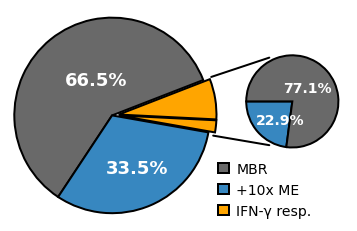

In [112]:
p_cols = [c for c in vdata if 'p-val' in c]
vdata = vdata.dropna(how='all', subset=p_cols)

ifn_wtME = len(vdata[(vdata['without ME'].isna()) & (vdata['IFN_Database'] != '')])
ifn_woME = len(vdata[(~vdata['without ME'].isna()) & (vdata['IFN_Database'] != '')])
other_woME = len(vdata[~vdata['without ME'].isna()]) - ifn_woME
other_wtME = len(vdata[vdata['without ME'].isna()]) - ifn_wtME

pie_data = [ifn_wtME, ifn_woME, other_woME, other_wtME]

fig, ax = plt.subplots(1, 1, figsize=(8,4))
plt.subplots_adjust(wspace=-0.35)

wedges, texts = plt.pie(pie_data, labels=['', '', '', ''], startangle=-10,
                       wedgeprops = {'edgecolor':'k', 'linewidth': lw}, shadow=False,
                       colors=['orange', 'orange', 'dimgrey', blues[13]], frame=False)

groups = [[0],[1],[2,3]]

radfraction = 0.034
for group in groups:
    ang = np.deg2rad((wedges[group[-1]].theta2 + wedges[group[0]].theta1) / 2)
    for j in group:
        center = radfraction * wedges[j].r * np.array([np.cos(ang), np.sin(ang)])
        wedges[j].set_center(center)
        texts[j].set_position(np.array(texts[j].get_position()) + center)
ax.autoscale(True)

mbr_perc = round((pie_data[1] + pie_data[2]) / np.sum(pie_data) *100, 1)
diame_perc = round((pie_data[0] + pie_data[3]) / np.sum(pie_data) *100, 1)
ax.text(-0.52, 0.31, str(mbr_perc)+'%', fontsize=fontsize+2, weight='bold', c='white')
ax.text(-0.1, -0.59, str(diame_perc)+'%', fontsize=fontsize+2, weight='bold', c='white')

ax2 = fig.add_axes([0.67, 0.35, 0.3, 0.4])

ax2.pie(pie_data[0:2], labels=['',''], startangle=180, wedgeprops = {'edgecolor':'k', 'linewidth': lw},
        shadow=False, colors=[blues[13], 'dimgrey'], frame=False)
con1 = mpl.patches.ConnectionPatch(xyA=(0.98, 0.39), xyB=(-0.5, 0.95), coordsA='data', coordsB='data', axesA=ax, axesB=ax2)
con2 = mpl.patches.ConnectionPatch(xyA=(1, -0.21), xyB=(-0.5, -0.95), coordsA='data', coordsB='data', axesA=ax, axesB=ax2)

for con in [con1, con2]:
    con.set_color('k')
    con.set_linewidth(lw)
    ax2.add_artist(con)
    
ifn_mbr_perc = round(pie_data[1] / (pie_data[0] + pie_data[1]) *100, 1)
ifn_diame_perc = round(pie_data[0] / (pie_data[0] + pie_data[1]) *100, 1)
ax2.text(-0.2, 0.2, str(ifn_mbr_perc)+'%', rotation=0, fontsize=fontsize-2, weight='bold', c='white')
ax2.text(-0.8, -0.5, str(ifn_diame_perc)+'%', rotation=0, fontsize=fontsize-2, weight='bold', c='white')   

legend = ax.legend(handles=[ax.patches[2], ax.patches[3], ax.patches[0]], labels=['MBR', '+10x ME', interferon+' resp.'],
                   framealpha=0, handlelength=0.8, ncol=1, columnspacing=-0.5, handletextpad=0.5, fontsize=fontsize-2,
                   loc=[0.95,0])
legend.get_frame().set_linewidth(0)

# plt.savefig('02_Figures/IFN_low-input_Volcano_PieChart.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/IFN_low-input_Volcano_PieChart.pdf', dpi=400, bbox_inches='tight')

E:\KK\03_Programs\Anaconda3\lib\site-packages\scipy\stats\mstats_basic.py:1077: RuntimeWarning: divide by zero encountered in true_divide
  denom = ma.sqrt(svar*(1.0/n1 + 1.0/n2))  # n-D computation here!
C:\Users\k689l\AppData\Local\Temp\ipykernel_13952\3654038857.py:21: UserWarning: Warning: converting a masked element to nan.
  mbr_vdata[col_name] = list(np.array(pvals))
E:\KK\03_Programs\Anaconda3\lib\site-packages\scipy\stats\mstats_basic.py:1077: RuntimeWarning: divide by zero encountered in true_divide
  denom = ma.sqrt(svar*(1.0/n1 + 1.0/n2))  # n-D computation here!
C:\Users\k689l\AppData\Local\Temp\ipykernel_13952\3654038857.py:21: UserWarning: Warning: converting a masked element to nan.
  mbr_vdata[col_name] = list(np.array(pvals))
E:\KK\03_Programs\Anaconda3\lib\site-packages\scipy\stats\mstats_basic.py:1077: RuntimeWarning: divide by zero encountered in true_divide
  denom = ma.sqrt(svar*(1.0/n1 + 1.0/n2))  # n-D computation here!
C:\Users\k689l\AppData\Local\Temp\ipykern

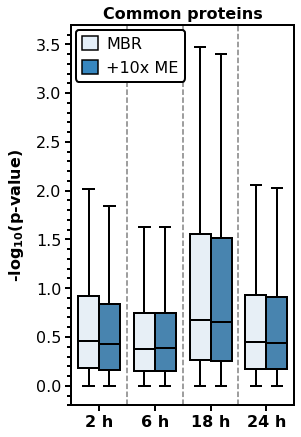

In [113]:
mbr = quans[0].copy()
mbr.columns = [c.split('_')[0] for c in mbr.columns]

mbr_vdata = pd.DataFrame()
medians = pd.DataFrame()
quan_vals = []

for i, tp in enumerate(timepoints):
    medians[tp] = np.log2(mbr[tp]).median(axis=1)
    quan_vals.append(mbr[tp].to_numpy(dtype=float))
    
    if i > 0:
        mbr_vdata['log fold ' + tp + ' - 0h'] = medians[tp].sub(medians['0h'])
        
        pvals = []
        for row in range(medians.shape[0]):
            ttest_result = stat.ttest_ind(quan_vals[i][row, :], quan_vals[0][row, :], nan_policy='omit')
            pvals.append(ttest_result[1])
            
        col_name = 'p-val ' + tp + ' - 0h'
        mbr_vdata[col_name] = list(np.array(pvals))
        mbr_vdata['log ' + col_name] = -1*np.log10(mbr_vdata[col_name])      
        
        rank = mbr_vdata[col_name].rank()
        padj = mbr_vdata[col_name] * rank.max() / rank
        mbr_vdata['log padj ' + tp + ' - 0h'] = -1*np.log10(padj)

mbr_vdata = mbr_vdata.dropna(how='all', subset=p_cols)

analyses = ['MBR', '+10x ME']
pval_data = []
for i, frame in enumerate([mbr_vdata, woME]):

    log_p_cols = [c for c in frame if 'log p-val' in c]
    pval_melt = frame[log_p_cols].melt().dropna()
    pval_melt['Timepoint'] = [r.split(' ')[2] for r in pval_melt['variable']]
    pval_melt['Experiment'] = analyses[i]
    pval_data.append(pval_melt)

pval_data = pd.concat(pval_data)

fig, ax = plt.subplots(1,1, figsize=(4,7))

sns.boxplot(data=pval_data, x='Timepoint', y='value', hue='Experiment', hue_order=analyses, width=0.75,
            showfliers=False, palette=[palette[0], palette[2]], linewidth=lw, ax=ax, linecolor='k',)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(lw)
    
ax.set_ylim([-0.2, 3.7])
ax.set_ylabel('-log'+r'$\bf{_{10}}$'+'(p-value)', fontsize=fontsize, fontweight='bold', labelpad=10)
ax.set_xlabel('')
ax.set_title('Common proteins', fontsize=fontsize, fontweight='bold')

ax.minorticks_on()
ax.tick_params(axis='both', which='major', length=lw*3, width=lw, labelsize=fontsize)
ax.tick_params(axis='x', which='minor', length=0)
ax.tick_params(axis='y', which='minor', length=lw*2, width=lw)
ax.set_xticklabels(tp_labels[1:5], fontweight='bold')
   
patches = []
for i in range(2):
    pa = mpl.patches.Patch(facecolor=palette[2*i], edgecolor='k', label=analyses[i], lw=lw-0.5)
    patches.append(pa)

for i in range(3):
    ax.axvline(x=(0.5 + i), color='grey', linestyle='dashed', lw=lw-0.5)
    
legend = ax.legend(handles=patches, loc=0, fontsize=fontsize, ncol=1, 
                     framealpha=1, borderaxespad=0.3, handletextpad=0.5, 
                     handlelength=1, handleheight=1, edgecolor='k')
legend.get_frame().set_linewidth(lw)

# plt.savefig('02_Figures/IFN_low-input_p-value_boxplot.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/IFN_low-input_p-value_boxplot.pdf', dpi=400, bbox_inches='tight')

C:\Users\k689l\AppData\Local\Temp\ipykernel_13952\1175545349.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yticklabels[i] = sig_ifn.index.get_level_values(1)[i].replace('HSP90AA1;', '').replace('HSP90AB1;', '')


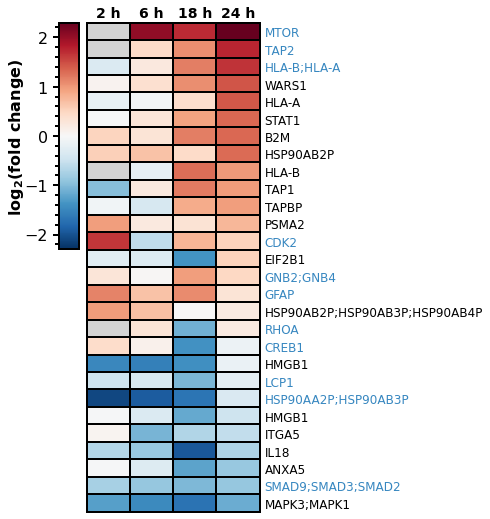

In [114]:
log_p_cols = [c for c in vdata if 'log p-val' in c]
log_f_cols = [c for c in vdata if 'log fold' in c]

sig_ifn = ifn_vdata.loc[(ifn_vdata[log_p_cols] > 1.3).any(axis=1)]
sig_ifn = sig_ifn.loc[(sig_ifn[log_f_cols] > 0.95).any(axis=1) |
                      (sig_ifn[log_f_cols] < -0.95).any(axis=1)].sort_values(by=log_f_cols[-1], ascending=False)

vmin, vmax = -2.3, 2.3

fig, ax = plt.subplots(1,1, figsize=(3.1, 9))
cbar_ax = plt.axes([0, 0.53, 0.09, 0.35])

yticklabels = sig_ifn['IFN_Database']
for i in range(len(yticklabels)):
    if yticklabels[i] == 'HSP90AA1':
        yticklabels[i] = sig_ifn.index.get_level_values(1)[i].replace('HSP90AA1;', '').replace('HSP90AB1;', '')

sns.heatmap(sig_ifn[log_f_cols], cmap=cmap2, vmin=vmin, vmax=vmax, linecolor='k', lw=lw-0.5,
            ax=ax, cbar_ax=cbar_ax, xticklabels=False, yticklabels=yticklabels)
ax.set_facecolor('lightgrey')

ax.set_ylabel('')

for axis in ['bottom', 'top', 'left', 'right']:
    ax.spines[axis].set_visible(True)
    ax.spines[axis].set_linewidth(lw)   
    cbar_ax.spines[axis].set_visible(True)
    cbar_ax.spines[axis].set_linewidth(lw)
    
ax.yaxis.set_label_position('right')
ax.yaxis.tick_right()
ax.tick_params(axis='both', which='major', labelsize=fontsize-4, length=0, labelrotation=0, pad=5)

cbar_ax.yaxis.set_ticks_position('left')
cbar_ax.yaxis.set_label_position('left')
cbar_ax.minorticks_on()
cbar_ax.tick_params(which='major', labelsize=fontsize, pad=5, width=lw, length=lw*3)
cbar_ax.tick_params(which='minor', width=lw, length=lw*2)
cbar_ax.set_ylabel('log'+r'$\bf{_{2}}$'+'(fold change)', fontsize=fontsize, fontweight='bold', labelpad=-2)

for i in range(4):
    ax.text(x=(0.5+i), y=-0.3, s=tp_labels[i+1], ha='center', color='k', fontsize=fontsize-2, fontweight='bold')

for i, label in enumerate(ax.get_yticklabels()):  
    if sig_ifn['without ME'][i] != '+':
        label.set_color(blues[13])

# plt.savefig('02_Figures/IFN_low-input_DE_heatmap.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/IFN_low-input_DE_heatmap.pdf', dpi=400, bbox_inches='tight')

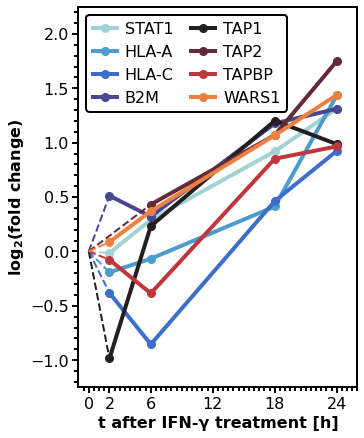

In [115]:
gene_list = ['STAT1', 'HLA-A', 'HLA-C', 'B2M', 'TAP1', 'TAP2', 'TAPBP', 'WARS1']
g_palette = sns.color_palette('icefire', len(gene_list)*3)

colors = [g_palette[0], g_palette[3], g_palette[5], g_palette[7], 
          g_palette[12], g_palette[15], g_palette[18], g_palette[21]]

g_data = ifn_vdata[ifn_vdata['IFN_Database'].isin(gene_list)].reset_index().set_index('IFN_Database')[log_f_cols]
g_data.columns = [c.split(' ')[2].replace('h','') for c in g_data]
g_data.columns = g_data.columns.to_numpy(dtype=float)
g_data = g_data.T

fig, ax = plt.subplots(1,1, figsize=(5,7))

handles = []
for gene, color in zip(gene_list, colors):
    ax.plot(g_data[gene], marker='o', linewidth=lw*2, markersize=8, c=color)
    
    xx = [0, 2]
    yy = [0, g_data[gene].iloc[0]]
    
    if gene == 'TAP2':
        xx = [0, 6]
        yy = [0, g_data[gene].iloc[1]]

    ax.plot(xx, yy, linestyle='dashed', linewidth=lw, markersize=8, c=color)
    
    line = mpl.lines.Line2D([], [], color=color, marker='o', lw=lw*2, markersize=8, label=gene)
    handles.append(line)
    
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(lw)

ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=fontsize, length=lw*3, width=lw)
ax.tick_params(axis='both', which='minor', labelsize=fontsize, length=lw*2, width=lw)

ax.set_xlabel('t after ' + interferon + ' treatment [h]', fontsize=fontsize, weight='bold')
ax.set_ylabel('log'+r'$\bf{_{2}}$'+'(fold change)', fontsize=fontsize, weight='bold', labelpad=4)

ax.set_xticks([0, 2, 6, 12, 18, 24])
ax.set_ylim([-1.25, 2.25])
ax.set_xlim([-1, 26])

legend = ax.legend(handles=handles, labels=gene_list, fontsize=fontsize, ncol=2, columnspacing=1.1, 
                   handlelength=1.5, handleheight=0.5, handletextpad=0.5, edgecolor='k', framealpha=1)
legend.get_frame().set_linewidth(lw)

# plt.savefig('02_Figures/IFN_low-input_Lineplot.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/IFN_low-input_Lineplot.pdf', dpi=400, bbox_inches='tight')

C:\Users\k689l\AppData\Local\Temp\ipykernel_13952\3484284423.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tp_labels, fontweight='bold')


Text(0.5, 1.0, 'Immunoproteasome')

E:\KK\03_Programs\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  fig.canvas.print_figure(bytes_io, **kw)
E:\KK\03_Programs\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  fig.canvas.print_figure(bytes_io, **kw)
E:\KK\03_Programs\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  fig.canvas.print_figure(bytes_io, **kw)
E:\KK\03_Programs\Anaconda3\lib\site-packages\IPython\core\pylab

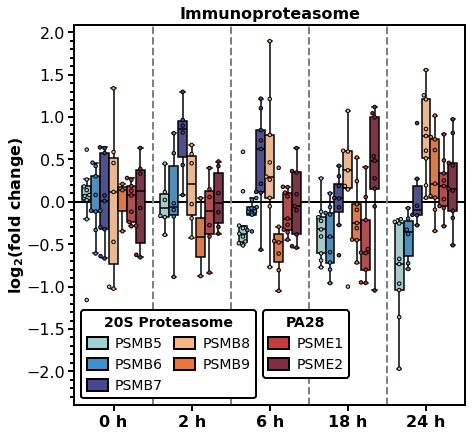

In [116]:
gene_list = ['PSMB5', 'PSMB6', 'PSMB7', 'PSMB8', 'PSMB9', 'PSME1', 'PSME2']
g_palette = sns.color_palette('icefire', len(gene_list)*3)

colors = [g_palette[0], g_palette[3], g_palette[6], 
          g_palette[20], g_palette[18], g_palette[16], g_palette[14]]

g_data = np.log2(diame[diame.index.get_level_values(1).isin(gene_list)].droplevel('Protein.Group')[timepoints])
base = np.mean(g_data['0h'], axis=1)

for i in range(len(g_data)):
    g_data.iloc[i] = g_data.iloc[i] - base[i]

g_data = g_data.melt(ignore_index=False).dropna()

fig, ax = plt.subplots(1,1, figsize=(7, 7))

ax.axhline(y=0, linewidth=lw, color='black', linestyle='solid', zorder=0)

sns.boxplot(data=g_data, y='value', x='variable', hue=g_data.index, hue_order=gene_list,
            palette=colors, linecolor='k', linewidth=lw-0.5, showfliers=False, ax=ax, zorder=1)
sns.swarmplot(data=g_data, y='value', x='variable', hue=g_data.index, hue_order=gene_list,
              palette=colors, dodge=True, edgecolor='black', linewidth=lw/2, size=3.5, ax=ax, zorder=2)

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(lw)
    
ax.set_ylim(ymin=-2.4)
ax.set_ylabel('log'+r'$\bf{_{2}}$'+'(fold change)', fontsize=fontsize, weight='bold', labelpad=0)
ax.set_xlabel('')

ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=fontsize, length=lw*3, width=lw)
ax.tick_params(axis='y', which='minor', labelsize=fontsize, length=lw*2, width=lw)
ax.tick_params(axis='x', which='minor', length=0)
ax.set_xticklabels(tp_labels, fontweight='bold')

for i in range(4):
    ax.axvline(x=(0.5+i), linewidth=lw, color='grey', linestyle='dashed')
    
handles =[]
for i in range(len(colors)):
    pa = mpl.patches.Patch(facecolor=colors[i], edgecolor='black', lw=2)
    handles.append(pa)

legend1 = ax.legend(title='20S Proteasome', title_fontproperties={'size': fontsize-2, 'weight': 'bold'},
                    handles=handles[0:5], labels=gene_list[0:5], fontsize=fontsize-2, ncol=2, columnspacing=0.8,
                    handlelength=1.5, handleheight=1, handletextpad=0.5, edgecolor='k', framealpha=1, loc=3)
ax.add_artist(legend1)
legend1.get_frame().set_linewidth(2)

legend2 = ax.legend(title='PA28', title_fontproperties={'size': fontsize-2, 'weight': 'bold'},
                    handles=handles[5:7], labels=gene_list[5:7], fontsize=fontsize-2, ncol=1, columnspacing=0.8,
                    handlelength=1.5, handleheight=1, handletextpad=0.5, edgecolor='k', framealpha=1, loc=(0.482, 0.073))
legend2.get_frame().set_linewidth(2)

ax.set_title('Immunoproteasome', fontsize=fontsize, weight='bold')

# plt.savefig('02_Figures/IFN_low-input_Proteasome_Boxplot.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/IFN_low-input_Proteasome_Boxplot.pdf', dpi=400, bbox_inches='tight')

E:\KK\03_Programs\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
E:\KK\03_Programs\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


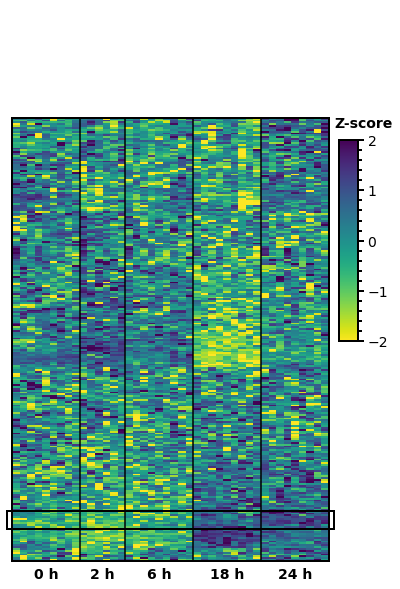

In [117]:
ifn_proteins = []
for row in diame.index.get_level_values(0).astype(str):
    ifn = [prot for prot in row.split(';') if prot in anno_set]
    ifn = [dictionary.get(item, item) for item in ifn]  
    ifn_proteins.append(';'.join(ifn))
diame.loc[:,('IFN_Database')] = ifn_proteins

# data imputation for hierarchical clustering
ifn_data = np.log2(diame[diame['IFN_Database'] != ''][timepoints])
for tp in timepoints:
    ifn_data = ifn_data.dropna(subset=tp, thresh=3)

imputed = KNNImputer(n_neighbors=5, weights='uniform').fit_transform(ifn_data.T)
ifn_data_i = pd.DataFrame(imputed, index=ifn_data.columns, columns=ifn_data.index).T

vmin = -2
vmax = 2
cbar_pos=(0.965,0.4,0.045,0.35)

clustermap = sns.clustermap(ifn_data_i, metric='euclidean', z_score=0, figsize=(6,8), col_cluster=False,
                            cmap=cmap, cbar_pos=cbar_pos, vmin=vmin, vmax=vmax, xticklabels=False, yticklabels=False)
clustermap.ax_row_dendrogram.set_visible(False)

heatmap = clustermap.ax_heatmap
cbar = clustermap.cax

heatmap.set_ylabel('')

for axis in ['top', 'bottom', 'left', 'right']:
    heatmap.spines[axis].set_visible(True)
    heatmap.spines[axis].set_linewidth(lw)
    
    cbar.spines[axis].set_visible(True)
    cbar.spines[axis].set_linewidth(lw)

cbar.minorticks_on()
cbar.tick_params(axis='y', which='major', length=lw*3, width=lw, labelsize=fontsize-2)
cbar.tick_params(axis='y', which='minor', length=lw*2, width=lw)
cbar.text(x=-0.2, y=vmax+0.25, s='Z-score', weight='bold', fontsize=fontsize-2) 

counter = 0
for i, tp in enumerate(timepoints):
    
    reps = len(ifn_data_i[tp].columns)
    heatmap.axvline(x=(reps + counter), lw=lw-0.5, color='k')
    
    label_pos = counter + reps/2
    heatmap.text(x=label_pos, y=len(ifn_data_i)*1.04, s=tp_labels[i], fontsize=fontsize-2, fontweight='bold', ha='center')
    counter += reps

# cluster in heatmap
width = len(ifn_data_i.columns)*1.03
cluster_upper = 211
cluster_lower = 221
  
xy = (-len(ifn_data_i.columns)*0.015, cluster_upper)    
height = cluster_lower - cluster_upper

rect = mpl.patches.Rectangle(xy, width, height, linewidth=lw, edgecolor='black', facecolor='none', alpha=1, clip_on=False)
heatmap.add_patch(rect)

new_ind = ifn_data_i.index[clustermap.dendrogram_row.reordered_ind]
clustered = ifn_data_i.loc[new_ind,:].reset_index()    

# plt.savefig('02_Figures/IFN_low-input_Clustermap_IFNresp.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/IFN_low-input_Clustermap_IFNresp.pdf', dpi=400, bbox_inches='tight')

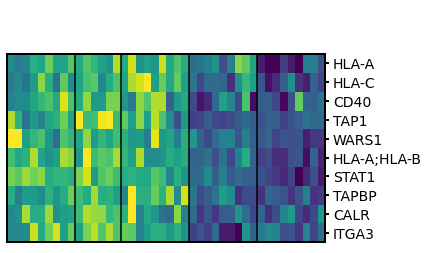

In [118]:
cluster = clustered[cluster_upper:cluster_lower].set_index(['Protein.Group', 'Genes'])

figsize_y = len(cluster) / 2.8
cbar_pos = (0.85,0.4,0.03,0.35)

clustermap = sns.clustermap(cluster, metric='euclidean', z_score=0, figsize=(7,figsize_y), col_cluster=False, 
                            cmap=cmap, cbar_pos=cbar_pos, vmin=vmin, vmax=vmax, xticklabels=False,
                            yticklabels=cluster.index.get_level_values(1).str.replace(';HLA-E;HLA-G', '')) 
clustermap.cax.remove()
clustermap.ax_row_dendrogram.set_visible(False)

heatmap = clustermap.ax_heatmap

heatmap.set_ylabel('')

heatmap.tick_params(axis='y', which='major', length=lw*2, width=lw, labelsize=fontsize-2)

for axis in ['top', 'bottom', 'left', 'right']:
    heatmap.spines[axis].set_visible(True)
    heatmap.spines[axis].set_linewidth(lw)

counter = 0
for i, tp in enumerate(timepoints):
    
    reps = len(ifn_data_i[tp].columns)
    heatmap.axvline(x=(reps + counter), lw=lw-0.5, color='k')
    counter += reps
    
# plt.savefig('02_Figures/IFN_low-input_Cluster_Up-regulated.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/IFN_low-input_Cluster_Up-regulated.pdf', dpi=400, bbox_inches='tight')

C:\Users\k689l\AppData\Local\Temp\ipykernel_13952\188892977.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=hms, x='Fold Enrichment ' + analyses[1], y='Pathway',
C:\Users\k689l\AppData\Local\Temp\ipykernel_13952\188892977.py:28: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(data=hms, x='Fold Enrichment ' + analyses[1], y='Pathway',
C:\Users\k689l\AppData\Local\Temp\ipykernel_13952\188892977.py:60: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  axs[1].set_yticks([])


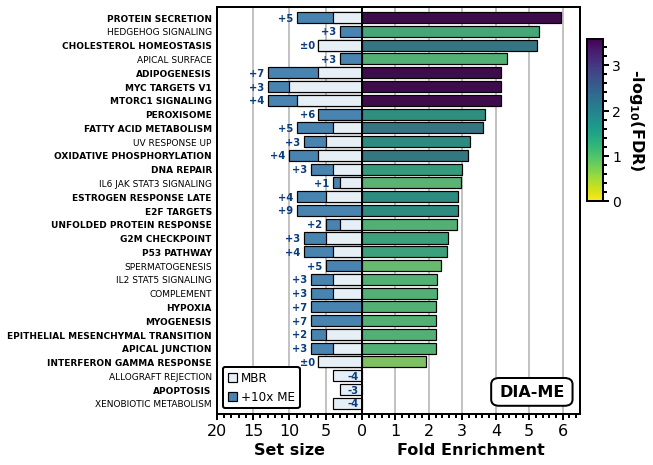

In [119]:
path6 = '01_Data/06_Enrichments/'

hm_diame = pd.read_csv(path6 + 'HallMark_directLFQ_FoldChanges_in_2ME_0h+24h.csv')
hm_mbr = pd.read_csv(path6 + 'WO-ME_HallmarkMSigDB_enrichment_all.csv')
hm_bulk = pd.read_csv(path6 + 'HallMark_KK27_Bulk_FoldChanges.csv')

cols = ['Enrichment FDR', 'nGenes', 'Pathway Genes', 'Fold Enrichment']
hms = [hm_mbr, hm_diame]

for i, hm in enumerate(hms):
    
    hms[i] = hm.set_index(hm['Pathway'].str.slice(9, 50)).drop(columns=['URL', 'Genes', 'Pathway Genes', 'Pathway'])
    hms[i]['Enrichment FDR'] = -np.log10(hms[i]['Enrichment FDR']) 
    
    for col in cols:
        hms[i].rename(columns={col: col + ' ' + analyses[i]}, inplace=True)

hms = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True, how='outer'), hms)
hms = hms.replace(np.nan, 0).sort_values(by='Fold Enrichment ' + analyses[1], ascending=False)

fig, ax = plt.subplots(1,2, figsize=(6.5,7.5), gridspec_kw={'width_ratios': [4, 6]})
plt.subplots_adjust(wspace=0)
axs = fig.axes

colormap = plt.get_cmap(cmap)
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
    
sns.barplot(data=hms, x='Fold Enrichment ' + analyses[1], y='Pathway', 
            palette=colormap(rescale(hms['Enrichment FDR ' + analyses[1]])), 
            edgecolor='k', lw=1.2, zorder=2, ax=axs[1])

sns.barplot(data=hms, x='nGenes ' + analyses[0], y='Pathway', color=blues[1], edgecolor='k', lw=1.2, zorder=3, ax=axs[0])
sns.barplot(data=hms, x='nGenes ' + analyses[1], y='Pathway', color=blues[13], edgecolor='k', lw=1.2, zorder=2, ax=axs[0])

for ax in axs:
    
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(lw)
    
    ax.grid(axis='x', which='major', linewidth=lw-0.5, zorder=0)
    
    ax.minorticks_on()
    ax.tick_params(axis='x', which='major', length=lw*3, width=lw, labelsize=fontsize)
    ax.tick_params(axis='x', which='minor', length=lw*2, width=lw)
    
    ax.tick_params(axis='y', which='major', length=0, labelsize=fontsize-7, pad=5)
    ax.tick_params(axis='y', which='minor', length=0)

    ax.set_ylabel('')
    ax.set_ylim(len(hms)-0.2, -0.8)

axs[0].set_xlabel('Set size', fontsize=fontsize, fontweight='bold')
axs[0].set_xlim(0, 20)
axs[0].set_xticks([5, 10, 15, 20])
axs[0].invert_xaxis()

axs[1].set_xlabel('Fold Enrichment', fontsize=fontsize, fontweight='bold')
axs[1].set_xlim(0, 6.5)
axs[1].set_xticks(range(7))
axs[1].set_yticks([])
axs[1].text(x=4.1, y=27.5, s='DIA-ME', fontsize=fontsize, weight='bold', bbox=props)

norm = mpl.colors.Normalize(vmin=hms['Enrichment FDR ' + analyses[1]].min(), 
                            vmax=hms['Enrichment FDR ' + analyses[1]].max())   
cbar_ax = plt.axes([0.915,0.52,0.035,0.3])    
cbar = mpl.colorbar.Colorbar(cbar_ax, cmap=cmap, norm=norm, orientation='vertical')
cbar.outline.set_edgecolor('k')
cbar.outline.set_linewidth(lw)
cbar_ax.set_ylabel('-log'+r'$\bf{_{10}}$'+'(FDR)', fontsize=fontsize, fontweight='bold', rotation=270, labelpad=25)
cbar_ax.minorticks_on()
cbar_ax.tick_params(axis='y', which='major', length=lw*3, width=lw, labelsize=fontsize-2)
cbar_ax.tick_params(axis='y', which='minor', length=lw*2, width=lw)

hms['Differenz'] = hms['nGenes ' + analyses[1]] - hms['nGenes ' + analyses[0]]

for i in range(hms.shape[0]):
    if hms['Differenz'][i] < 0:
        diff = str(int(hms['Differenz'][i]))
    elif hms['Differenz'][i] == 0:
        diff = u'\u00b1' + '0'
    elif hms['Differenz'][i] > 0:
        diff = '+' + str(int(hms['Differenz'][i]))
        
    axs[0].text(x=hms['nGenes ' + analyses[1]][i]+0.5, y=(0.25+i), s=diff, fontsize=fontsize-6, 
                weight='bold', ha='right', color=blues[19])
        
legend = axs[0].legend(handles=[axs[0].patches[0], axs[0].patches[-1]], labels=analyses, edgecolor='k', framealpha=1,
                   handlelength=0.8, ncol=1, columnspacing=-0.5, handletextpad=0.3, loc=3, fontsize=fontsize-4)
legend.get_frame().set_linewidth(lw)
        
bulk_terms = hm_bulk['Pathway'].str.slice(9,50)
plt.draw()

for tick in axs[0].get_yticklabels():
    label = tick.get_text()
    if label in list(bulk_terms):
        tick.set_weight('bold')

# plt.savefig('02_Figures/IFN_low-input_MSigDB_Enrichments_upreg.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/IFN_low-input_MSigDB_Enrichments_upreg.pdf', dpi=400, bbox_inches='tight')